# 05_LargeScale_Maps
Relation to large-scale patterns of atm. forcing

In [85]:
%load_ext autoreload
%autoreload 2

# general
import numpy as np, numpy.ma as ma
import xarray as xr
import pandas as pd

# time
from datetime import datetime, timedelta
import calendar
from calendar import monthrange

# local system 
import sys  
import glob
import os

# plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors
import cmocean
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import Normalize
from matplotlib.ticker import MultipleLocator

import matplotlib.dates as mdates


from scipy import stats


# geo plotting
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeat
from cartopy import img_transform

from metpy.units import units

# path to own functions
sys.path.append('../../')
import timeseries.adjust as tseries
import timeseries.analyze as tanalyze
import geofunc.general as geogen
import geofunc.vectors as vectors
import geofunc.shapes as geoshape
import plot_simply.general as plotter
import plot_simply.geomap as geomap
import data_NSIDC.icedrift as icedrift
import data_UniBremen.SIC as unisic


sys.path.append('../')
import functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Import constants

In [86]:
# Save to file
df = pd.read_csv('../data/constants.csv')
df = df.set_index('var')
df

cst = {}
for variable in list(df.index):
    cst[variable] = df.loc[variable]['value'] * units(df.loc[variable]['units'])
    
cst

{'Cp_o': <Quantity(3850.0, 'joule / kilogram / delta_degree_Celsius')>,
 'Cp_a': <Quantity(1004.0, 'joule / kilogram / delta_degree_Celsius')>,
 'sigma_sb': <Quantity(5.670367e-08, 'watt / meter ** 2 / kelvin ** 4')>,
 'rho_a': <Quantity(1.225, 'kilogram / meter ** 3')>,
 'rho_o': <Quantity(1028.0, 'kilogram / meter ** 3')>,
 'rho_i': <Quantity(917.0, 'kilogram / meter ** 3')>,
 'L_i': <Quantity(334000.0, 'joule / kilogram')>,
 'k_i': <Quantity(2.2, 'watt / meter / delta_degree_Celsius')>,
 'kappa': <Quantity(0.4, 'dimensionless')>,
 'St': <Quantity(0.0057, 'dimensionless')>,
 'omega': <Quantity(7.2921e-05, 'radian / second')>}

## Reference grids

In [87]:
grids = {}

# ERA5
#-----
# era_lat_range = slice(74,68)
# era_lon_range = slice(-165,-125)

era_lat_range = slice(90,65)
era_lon_range = slice(-180,180)
ds = xr.open_dataset(f'/Volumes/Jewell_EasyStore/ECMWF/annual/daily/ERA5_2024_daily.nc')
ds.close()
ds = ds.sel(latitude = era_lat_range, longitude = era_lon_range)
longrid, latgrid = np.meshgrid(ds.longitude, ds.latitude)

grids['era'] = {}
grids['era']['lat'] = latgrid
grids['era']['lon'] = longrid


# PPD drift
#----------
drift = icedrift.open_local_file(datetime(2023,1,1), crop = [200,300,110,200],include_units = False)
drift['lon'][drift['lon']>180]-=360
grids['ppd'] = {}
grids['ppd']['lat'] = drift['lat']
grids['ppd']['lon'] = drift['lon']
grids['ppd']['xx'] = drift['xx']
grids['ppd']['yy'] = drift['yy']


# open regional bounding coordinates
df = pd.read_csv('../data/coastal_region_bounds_v6.csv')
reg_poly = geoshape.make_polygon(np.stack((df['lons'], df['lats']), axis=1))


from shapely.geometry import Point

for key in grids.keys():
    print(key)
    
    grids[key]['region'] = np.full(grids[key]['lon'].shape, False)

    for ii in range(np.shape(grids[key]['region'])[0]):
        for jj in range(np.shape(grids[key]['region'])[1]):

            lon, lat = grids[key]['lon'][ii,jj], grids[key]['lat'][ii,jj]
            if lon > 180:
                lon-=360

            if reg_poly.contains(Point(lon, lat)):
                
                if lon > -160:
                    grids[key]['region'][ii,jj] = True
                

era
ppd


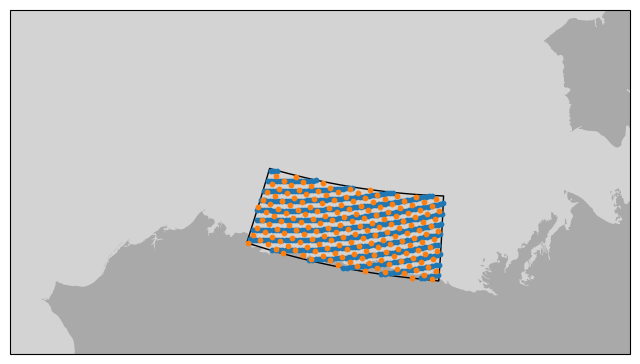

In [88]:

# initialize map
map_proj = ccrs.NorthPolarStereo(central_longitude=-150)
fig, ax = plt.subplots(subplot_kw=dict(projection=map_proj), figsize=(8,6))
ax.set_ylim(-2500000,-1500000)
ax.set_xlim(-800000,1000000)
ax.set_facecolor('lightgray')
geomap.land(ax, scale = '10m', color='darkgray', alpha=1, fill_dateline_gap = False, zorder=2)


ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


for key in ['era', 'ppd']:
    ax.scatter(grids[key]['lon'][grids[key]['region']], grids[key]['lat'][grids[key]['region']], 
               zorder=100, s = 10, transform=ccrs.PlateCarree())


In [154]:
ds = xr.open_dataset('/Volumes/Seagate_Jewell/KenzieStuff/SBSpolynya_data/open_freqs_2002-2025_M4.nc')
sic = unisic.open_local_file(datetime(2020,1,1), res='6250', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', crop=[0, None, 0, None], coordinates=False, area=False, include_units=False, quiet=True)


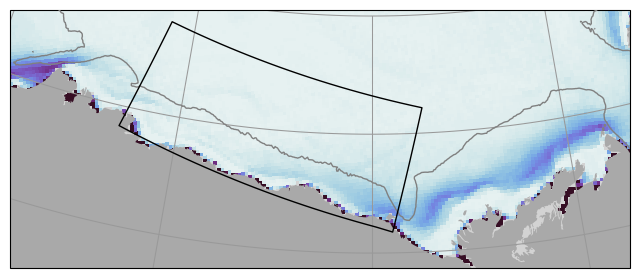

In [166]:
fig, ax = fn.makemap(view='wide', contours = [-100])

ax.pcolormesh(ds.xx, ds.yy, ma.masked_where(np.isnan(ds.sic10), ds.sic70), 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=sic['proj'])
ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    


In [7]:

# key = 'era'
# mainpath = '../data/forcing/'
# filename = f"dailymaps_{key}_v0.nc"
# ds = xr.open_dataset(mainpath+filename)

## Identify continuous polynya sequences

In [281]:

all_seqs = {}
all_sizes = {}

event_dates = {}
event_dates['all'] = np.array([], dtype=np.datetime64)
event_dates['large'] = np.array([], dtype=np.datetime64)
event_dates['small'] = np.array([], dtype=np.datetime64)
event_dates['comp'] = np.array([], dtype=np.datetime64)

#===============================
years = np.append(np.arange(2003,2012), np.arange(2013,2024))
# years = np.arange(2003,2026)

size_thresh = 0      # polynya must reach this size at some point to be counted as event (km2)
start_size_thresh = 0  # size of openings to include as full window of event (km2)
large_size = 500
#===============================

days_per_year = []
events_per_year = []


for year in years:
    
    print(year)
    
    # open data and crop to time range
    DS = xr.open_dataset(f'../data/polynya_size/daily_polynya_{year}_sic10_v6.nc')
    time_range = slice(datetime(year-1,12,1), datetime(year,4,30))
    DS = DS.sel(time = time_range)
    
    
    event_dates['all'] = np.append(event_dates['all'], DS.time[DS.polynya_extent > 0])
    event_dates['large'] = np.append(event_dates['large'], DS.time[DS.polynya_extent >= 500])
    event_dates['small'] = np.append(event_dates['small'], DS.time[DS.polynya_extent < 500])
    event_dates['comp'] = np.append(event_dates['comp'], DS.time[DS.polynya_extent == 0])
    
    
    
    
    # identify open periods
    open_cond = (DS.polynya_extent > start_size_thresh) #& (DS.ocean_extent == 0)
    open_dates = pd.to_datetime(DS.time[open_cond].values)
    days_per_year.append(len(open_dates))
    
    open_seqs = tseries.dates_to_sequences(open_dates, dt_max = 1 * units('day'))
    events_per_year.append(len(open_seqs))
    
    large_seqs = {}
    
    cc = 0
    for jj in range(len(open_seqs)):
        # if polynya reach size threshold during event, add to algre sequences
        if np.sum(DS.sel(time = open_seqs[jj]).polynya_extent.values > size_thresh) > 0:
            large_seqs[cc] = open_seqs[jj]
            cc+=1
        
    
    # add to master list
    ii = len(all_seqs)
    
    CC = 0
    for cc in range(len(large_seqs)):
        if len(large_seqs[cc]) > 0:
            all_seqs[ii+CC] = large_seqs[cc]
            all_sizes[ii+CC] = DS.extent.sel(time = large_seqs[cc]).values
            CC+=1
            
            
    
            
        
        

2003
2004
2005
2006
2007
2008
2009
2010
2011
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


In [186]:
all_polynya_durations = np.array([])
all_polynya_sizes = np.array([])
max_polynya_sizes = np.array([])

for ss in all_sizes:
    
    all_polynya_sizes = np.append(all_polynya_sizes, all_sizes[ss])
    max_polynya_sizes = np.append(max_polynya_sizes, all_sizes[ss].max())
    all_polynya_durations = np.append(all_polynya_durations, len(all_sizes[ss]))

1444.3208645820462
155.8976974160937
4528.585283972152


<>:26: SyntaxWarning: invalid escape sequence '\m'
<>:26: SyntaxWarning: invalid escape sequence '\m'
/var/folders/p8/hz449fpx6nscv0jb1klyfqb40000gp/T/ipykernel_12152/836383104.py:26: SyntaxWarning: invalid escape sequence '\m'
  plt.xlabel('Polynya size ($\mathrm{km^{2}}$)')


Text(0.5, 0, 'Polynya size ($\\mathrm{km^{2}}$)')

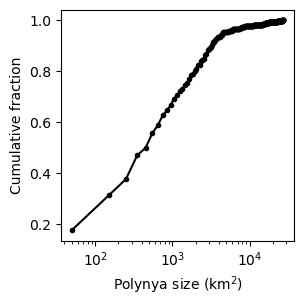

In [279]:

fig, ax = plt.subplots(figsize=(3,3))

bins = np.arange(0,27500,100)

x = all_polynya_sizes
h = plotter.quick_hist(x, bin_edges = bins)
# ax.bar(np.log(h['centers']), h['counts'], width = h['w'], alpha=0.5)

ax.set_xticks([0,10,100,1000,1000])
ax.set_xscale('log')

ax.semilogx(h['centers'], np.cumsum(h['counts'])/np.sum(h['counts']), marker='.', c='k')
# ax2 = ax.twinx()
# ax2.semilogx(h['centers'], h['counts']/np.sum(h['counts']), marker='.', c='k')


# ax2.set_xscale('log')

print(np.nanmean(x))
print(np.nanpercentile(x, 25))
print(np.nanpercentile(x, 95))

# ax.set_ylim(0,10)

plt.ylabel('Cumulative fraction')
plt.xlabel('Polynya size ($\mathrm{km^{2}}$)')

In [ ]:

fig, ax = plt.subplots(figsize=(3,3))

bins = np.arange(0.5,20.5,1)

x = all_polynya_durations
h = plotter.quick_hist(x, bin_edges = bins)
ax.bar(h['centers'], h['counts'], width = h['w'], alpha=0.5)

ax2 = ax.twinx()
ax2.plot(h['centers'], np.cumsum(h['counts'])/np.sum(h['counts']), marker='.', c='k')
print(np.nanmean(x))
print(np.nanpercentile(x, 25))
print(np.nanpercentile(x, 95))

(array([83., 37., 14.,  3.,  0.,  5.,  4.,  0.,  1.,  1.]),
 array([ 1. ,  2.8,  4.6,  6.4,  8.2, 10. , 11.8, 13.6, 15.4, 17.2, 19. ]),
 <BarContainer object of 10 artists>)

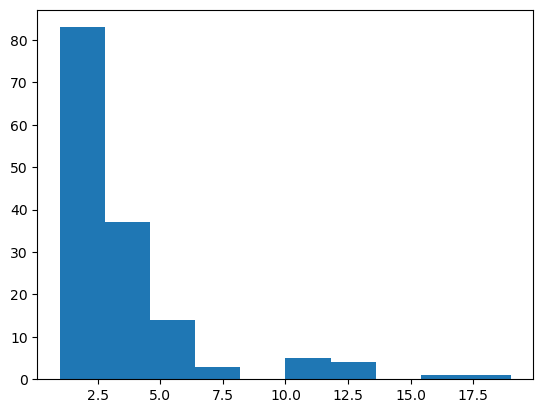

In [194]:
plt.hist(all_polynya_durations)

In [192]:
np.sum(all_polynya_durations)/(20*150)

0.15733333333333333

In [171]:
len(all_seqs)

148

In [170]:
len(all_sizes)

148

### Grab SIC maps

In [283]:

# RES = '1000ma2'
# crop = [2100, 3400, 340, 800]
# sic_key = 'sic_merged'

RES = '6250'
crop=[500, 1300, 100, 500]
sic_key = 'sic'

# RES = '3125'
# crop=[1500, 2050, 480, 700]
# sic_key = 'sic'

# sicsic = unisic.open_local_file(datetime(2019,1,16), res='1000ma2', hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
#                             crop=[2100, 3400, 340, 800], coordinates=False, area=False, include_units=False, quiet=True)


dsic = unisic.open_local_file(datetime(2020,1,1), res=RES, hem='n', main_path='/Volumes/Seagate_Jewell/KenzieStuff/',
                                  crop=crop, coordinates=True, area=False, include_units=False, 
                                  quiet=True)

open_thresh=10

map_sic = {}

for key in event_dates.keys():

    print(key)
    map_sic[key] = unisic.calc_meansic_openfreq(pd.to_datetime(event_dates[key]), crop=crop, 
                                            open_thresh=open_thresh, res=RES, hem='n', sic_key = sic_key, 
                                            main_path='/Volumes/Seagate_Jewell/KenzieStuff/', 
                                            coordinates=False, area=False, quiet=True)


all
large
small
comp


In [284]:
map_sic[key].keys()

dict_keys(['xx', 'yy', 'sic_mean', 'open_freq', 'missing_dates'])

In [ ]:
fig, ax = fn.makemap(view='wide', contours = [-100])


ax.pcolormesh(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
              vmin=0, vmax=0.5, cmap=cmocean.cm.dense, transform=dsic['proj'])

ax.contour(map_sic[key]['xx'], map_sic[key]['yy'], map_sic[key]['open_freq'], 
            levels=[0.1,0.2,0.3,0.4,0.5], linewidths=[0.5],colors=['k'], transform=dsic['proj'])

ax.add_geometries([reg_poly], edgecolor='k', facecolor='None',zorder=100, crs=ccrs.PlateCarree())


line_kwargs = {'lw':0.75, 'c':[0.6,0.6,0.6]}
for lat in [69,71,73]:
    ax.plot(np.linspace(-160,-120,100), np.full(100,lat), transform=ccrs.PlateCarree(), **line_kwargs)  
for lon in [-160,-150,-140,-130]:
    ax.plot(np.full(100,lon), np.linspace(68,73,100), transform=ccrs.PlateCarree(), **line_kwargs)
    